In [15]:
import pickle
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn as sns

In [16]:
pd.set_option('display.max_columns', 50)

# Load Data

In [20]:
with open('../../data/interim/rDemocrats_doc_topic.pickle', 'rb') as read_file:
    doc_topic = pickle.load(read_file)

In [21]:
with open('../../data/interim/rDemocrats_data_clean.pickle', 'rb') as read_file:
    data_clean = pickle.load(read_file)

In [22]:
data_join = data_clean.reset_index().join(doc_topic)

# EDA - Topic Distributions

## Raw Distribution

In [23]:
data_join['total_topic_score'] = data_join.apply(lambda x: np.sum(x['2016_election_frustration':'miltary_and_immigration']), axis=1)

for topic in data_join.columns[4:22]:
    data_join[topic + '_perc'] = data_join[topic] / data_join['total_topic_score']

In [24]:
def get_primary_topic(row, threshold=0.25):
    topic_weights = row['2016_election_frustration_perc':'miltary_and_immigration_perc'].sort_values()
    max_perc, primary_topic = topic_weights[-1], topic_weights.index[-1]
    sec_perc, sec_topic = topic_weights[-2], topic_weights.index[-2]
    
    return primary_topic, max_perc, sec_topic, sec_perc

def label_primary_topic(df):
    df_ = df.copy()
    series = df_.apply(get_primary_topic, axis=1)
    primary_topic, max_perc, sec_topic, sec_perc = series.map(lambda x: x[0]), series.map(lambda x: x[1]), series.map(lambda x: x[2]), series.map(lambda x: x[3])
    df_['primary_topic'] = primary_topic
    df_['max_topic_perc'] = max_perc
    df_['secondary_topic'] = sec_topic
    df_['secondary_topic_perc'] = sec_perc
    return df_

In [25]:
data_labeled = label_primary_topic(data_join)

In [26]:
data_labeled.primary_topic.value_counts()

2016_election_frustration_perc    94
impeachment_perc                  75
primary_candidates_perc           59
election_general_terms_perc       55
rep_dem_comparison_perc           54
right_wing_media_perc             40
primary_debates_perc              34
miltary_and_immigration_perc      30
race_identity_perc                25
election_midwest_swing_perc       21
gun_control_perc                  20
yang_ubi_perc                     20
econ_trump_vs_obama_perc          19
healthcare_perc                   18
bloomberg_perc                    17
tax_return_ukraine_biden_perc     14
monetary_policy_perc               5
impeachment_proceedings_perc       4
Name: primary_topic, dtype: int64

## Are some documents really none of the topics?

In [27]:
# replace topic with "none" if the primary topic is less than 20% of the total topoic score
data_labeled['topic_label'] = np.where(data_labeled.max_topic_perc > 0.2, data_labeled.primary_topic, 'none')

In [28]:
data_labeled.topic_label.value_counts()

2016_election_frustration_perc    85
impeachment_perc                  69
primary_candidates_perc           57
rep_dem_comparison_perc           52
election_general_terms_perc       50
none                              48
right_wing_media_perc             39
primary_debates_perc              33
miltary_and_immigration_perc      25
race_identity_perc                20
gun_control_perc                  20
election_midwest_swing_perc       18
healthcare_perc                   18
bloomberg_perc                    17
yang_ubi_perc                     16
econ_trump_vs_obama_perc          16
tax_return_ukraine_biden_perc     12
monetary_policy_perc               5
impeachment_proceedings_perc       4
Name: topic_label, dtype: int64

In [29]:
for topic in data_labeled.columns[4:22]:
    data_labeled[topic + '_per_word'] = data_labeled[topic] / data_labeled['word_count']
    
data_labeled[data_labeled.topic_label == 'none']\
    .apply(lambda x: np.max(x['2016_election_frustration_per_word':'miltary_and_immigration_per_word']), axis=1).describe()

count    48.000000
mean      0.000285
std       0.000054
min       0.000181
25%       0.000243
50%       0.000280
75%       0.000322
max       0.000404
dtype: float64

In [30]:
s = data_labeled\
    .apply(lambda x: np.max(x['2016_election_frustration_per_word':'miltary_and_immigration_per_word']), axis=1)

data_labeled['per_word_topic_label'] = s.where(s > 0.0003, 'none')

In [31]:
# Docs that don't meet percentage cutoff
data_labeled[data_labeled.topic_label == 'none'].shape

(48, 65)

In [32]:
# Docs that don't meet per word cutoff
data_labeled[data_labeled.per_word_topic_label == 'none'].shape

(37, 65)

In [33]:
# Docs that don't meet per_word or percentage cutoffs
data_labeled[(data_labeled.per_word_topic_label == 'none') & (data_labeled.topic_label == 'none')].shape

(27, 65)

In [34]:
# 10 that don't meet the per word cutoff but do meet the concentration cutoff
# 21 don't meet the concentration cutoff but do meet the per word score cutoff
# Difference negligible given size of data set

In [35]:
with open('../../data/interim/rDemocrats_doc_topic_labeled.pickle', 'wb') as write_file:
    pickle.dump(data_labeled, write_file)

# Clustering

In [36]:
scaler = MinMaxScaler()
doc_topic_std = scaler.fit_transform(doc_topic)

## K-means

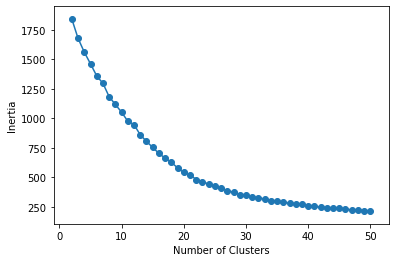

In [37]:
inertia = []
sil_scores = []
list_num_clusters = list(range(2,51))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters, random_state=42)
    preds = km.fit_predict(doc_topic)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(doc_topic_std, preds))
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

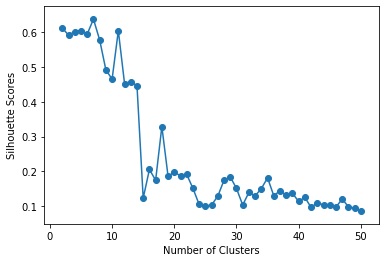

In [38]:
plt.plot(list_num_clusters,sil_scores)
plt.scatter(list_num_clusters,sil_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Scores');

In [39]:
km = KMeans(n_clusters=11, random_state=42)
km_model = km.fit_predict(doc_topic_std)
pd.DataFrame(km_model).iloc[:, 0].value_counts()

0     386
9     148
2      27
1      18
4      13
8       4
7       2
6       2
3       2
10      1
5       1
Name: 0, dtype: int64

In [40]:
# Dimensionality might be too high
# lots of outliers, let's try a non-partioning algo
# seems like there's one dense region and then lots of outliers

## DBSCAN

In [41]:
db = DBSCAN(eps=.2, min_samples=10, metric='cosine').fit(doc_topic_std)
pd.DataFrame(db.labels_).iloc[:, 0].value_counts()

 0    514
-1     77
 1     13
Name: 0, dtype: int64

## Hierarchical Clustering

In [42]:
db = AgglomerativeClustering(n_clusters=None, distance_threshold=.8, linkage='average', affinity='cosine').fit(doc_topic_std)
pd.DataFrame(db.labels_).iloc[:, 0].value_counts()

0    568
2     19
1     16
3      1
Name: 0, dtype: int64

## Mean Shift

In [43]:
# estimate bandwidth 
bandwidth = estimate_bandwidth(doc_topic_std, quantile=0.9, random_state=42)

ms = MeanShift(bandwidth=bandwidth, cluster_all=False)
ms.fit(doc_topic_std)
pd.DataFrame(ms.labels_).iloc[:, 0].value_counts()

 0     563
-1      19
 1       2
 2       2
 19      1
 18      1
 3       1
 4       1
 5       1
 6       1
 7       1
 8       1
 9       1
 20      1
 11      1
 12      1
 13      1
 14      1
 15      1
 16      1
 17      1
 10      1
Name: 0, dtype: int64

## Spectral Clustering Affinity Propogation

In [44]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=3, random_state=42)
ypred = sc.fit_predict(doc_topic_std)
pd.DataFrame(ypred).iloc[:, 0].value_counts()

0    548
1     36
2     20
Name: 0, dtype: int64

In [45]:
pd.DataFrame(doc_topic_std)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.055337,0.001028,0.001416,0.000000,0.000000,0.040165,0.008595,0.007771,0.003270,0.000000,0.000000,0.003817,0.000000,0.004232,0.000000,0.002306,0.036751,0.000000
1,0.009407,0.000000,0.002492,0.000000,0.010319,0.000000,0.016074,0.000000,0.022900,0.000000,0.014089,0.000000,0.021479,0.022666,0.000000,0.010719,0.023699,0.020872
2,0.001926,0.000000,0.000000,0.044540,0.000641,0.070814,0.006391,0.000000,0.000000,0.087737,0.000000,0.000000,0.024671,0.018006,0.035788,0.002815,0.000000,0.000000
3,0.755913,0.000000,0.000000,0.000000,0.000000,0.237086,0.000000,0.000000,0.016836,0.127967,0.002282,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
4,0.000000,0.000000,0.050787,0.063403,0.012669,0.000000,0.000000,0.000000,0.072704,0.072319,0.000000,0.000000,0.000953,0.019279,0.000000,0.000000,0.000000,0.033630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,0.210087,0.007365,0.000000,0.004059,0.017927,0.061438,0.014703,0.103212,0.009589,0.000000,0.000000,0.016173,0.006840,0.000216,0.000000,0.000000,0.054704,0.004465
600,0.000000,0.008428,0.000000,0.000000,0.005944,0.059171,0.000000,0.089586,0.000000,0.000000,0.025615,0.016618,0.000000,0.000000,0.080036,0.000000,0.000000,0.063175
601,0.000000,0.000475,0.000000,0.000000,0.003484,0.013148,0.000000,0.046211,0.000000,0.000000,0.000883,0.000000,0.013563,0.000000,0.006639,0.001078,0.069598,0.008017
602,0.076583,0.000000,0.007027,0.013559,0.000000,0.036098,0.000000,0.024939,0.012601,0.022400,0.005199,0.000000,0.003851,0.000000,0.001163,0.000000,0.020144,0.000000


# Take Aways

- Lots of outliers and then one dense region
- Perhaps consider dropping a bunch of the common words
    - play with max_df
    - In theory, the topics sharing words is making the clustering break down
